In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Note EWKino_CLs_train.csv and EWKino_CLs_test.csv are already normalised to mean=0 and std=1 on every column that isn't CLs
df = pd.read_csv("../csv-files/EWKino_normalised_inputs_train.csv")
input_parameters = ["M_1", "M_2", "mu", "tan_beta", "M_3", "At", "Ab", "Atau", "mA", "mqL3", "mtR", "mbR", "Final__CLs"]
train = df[input_parameters]

In [100]:
def neg_linear_loss(y_true, y_pred):

    # Calculate absolute error for each prediction
    abs_error = tf.abs(y_true - y_pred)
    
    # Weight to focus on values close to zero
    weighted_error = abs_error * (1 + (1 - y_true))

    # Return weighted MAE as loss
    loss = tf.reduce_mean(weighted_error)
    return loss

def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.005),
        loss=neg_linear_loss,
        metrics=["mae"]
    )
    
    return model

In [101]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    # Shuffle the entire training dataset
    shuffled_df = df.sample(frac=1)
    
    # Separate the inputs and target outputs into train and labels respectively
    labels = shuffled_df.pop("Final__CLs")
    train = shuffled_df
    num_val_samples = len(train) // k
    if k == 1:
        num_val_samples = len(train) // 5
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [102]:
# Choose number of folds for k-fold validation, number of epochs, and iterations
k = 1
num_epochs = 400 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 2 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)

# avg_train_accuracy and avg_val_accuracy store the training and validation accuracy for each epoch, averaged over the k folds
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    #print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, train)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

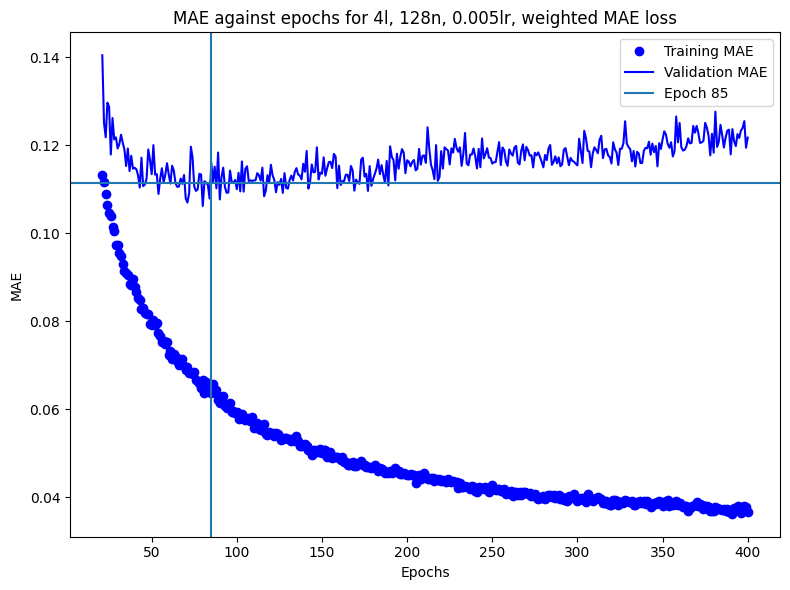

In [108]:
# Plot training and validation accuracy for each epoch

best_epoch = 85
cut = 20
epochs = range(cut+1, num_epochs + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training MAE")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation MAE")
plt.axvline(best_epoch, label=f"Epoch {best_epoch}")
plt.axhline(0.1115)      
plt.title("MAE against epochs for 4l, 128n, 0.005lr, weighted MAE loss") 
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
#plt.savefig("./training_plot_weighted_MAE_128n_then_64.png")
plt.show()

In [120]:
# Train new model on all of the available data

df = pd.read_csv("../csv-files/EWKino_normalised_inputs_train.csv")
labels = df.pop("Final__CLs")
train = df[input_parameters[:-1]]

model = build_model()

history = model.fit(
    train,
    labels,
    epochs=85, # Change this depending on when the model starts overfitting
    verbose=0
)

In [121]:
model.save('neg_lin_loss_model.keras')

In [ ]:
"""
This is the code block for storing predictions and targets alone in separate dataframe
# Read in the test file that the model has not seen
test = pd.read_csv("csv-files/EWKino_Is_Valid_test.csv")

# Store the ground truth we are hoping to predict in targets
targets = test.pop("Is_Valid").values

data = {'Targets': targets,
        'Predictions': predictions}
"""

# This code reads in test file, use trained model to predict value of interest, and store the predicted values and original targets
test = pd.read_csv("../csv-files/EWKino_normalised_inputs_test.csv")
test_inputs = test[input_parameters[:-1]]

# Create copy so we are not editing original df
test_plus_predictions = test.copy()

model = tf.keras.models.load_model("neg_lin_loss_model.keras", compile=False)
model.compile(optimizer=keras.optimizers.RMSprop(0.005), loss=neg_linear_loss, metrics=["mae"])

# Predict the DM relic densities using our model. Using .flatten() turns predictions into a 1D array that can be put into a dataframe
predictions = model.predict(test_inputs).flatten()
test_plus_predictions["Predicted_Final__CLs"] = predictions

# Save the predictions of the model
#test_plus_predictions.to_csv("test_neg_lin_loss.csv", index=False)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
